In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")
plt.rcParams["figure.figsize"] = [12, 4]

In [ ]:
def entropy(labels):
    values, counts = np.unique(labels, return_counts=True)
    probs = counts / len(labels)
    return -np.sum(probs * np.log2(probs + 1e-9))


def dynamic_shapelets(time_series, labels, min_len=5, max_len=None, top_k=1):
    # Generate candidates
    candidates = []
    max_len = max_len or min(map(len, time_series))
    for series in time_series:
        for length in range(min_len, max_len + 1):
            for start in range(len(series) - length + 1):
                candidates.append(series[start:start + length])
    
    # Evaluate candidates
    shapelet_scores = []
    for shapelet in candidates:
        length = len(shapelet)
        distances = [min(euclidean(shapelet, ts[i:i+length]) 
                     for i in range(len(ts) - length + 1)) 
                     for ts in time_series]
        
        # Information gain calculation
        split = np.median(distances)
        left_labels = [labels[i] for i in range(len(labels)) if distances[i] <= split]
        right_labels = [labels[i] for i in range(len(labels)) if distances[i] > split]

        h_before = entropy(labels)
        h_after = (len(left_labels) * entropy(left_labels) + 
                  len(right_labels) * entropy(right_labels)) / len(labels)
        gain = h_before - h_after
        
        shapelet_scores.append((gain, shapelet))
    
    # Return top k shapelets
    shapelet_scores.sort(reverse=True, key=lambda x: x[0])
    return [s[1] for s in shapelet_scores[:top_k]]

In [13]:

def extract_fixed_windows(time_series, window_size):
    """Extract all fixed-size windows from the time series."""
    windows = []
    for series in time_series:
        for start in range(len(series) - window_size + 1):
            windows.append(series[start:start + window_size])
    return np.array(windows)

def fixed_shapelets(time_series, labels, window_size, top_k=1, n_clusters=10):
    # Extract fixed-size windows
    windows = extract_fixed_windows(time_series, window_size)
    
    # Cluster windows using k-means with DTW
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=42, verbose=1, n_jobs=-1, tol=1e-2)
    kmeans.fit_predict(windows)
    cluster_centers = kmeans.cluster_centers_
    
    shapelet_scores = []
    for shapelet in tqdm(cluster_centers):
        distances = [
            min(dtw(shapelet, ts[i:i+window_size]) for i in range(len(ts) - window_size + 1))
            for ts in time_series
        ]
        
        # Information gain calculation
        split = np.median(distances)
        left_labels = [labels[i] for i in range(len(labels)) if distances[i] <= split]
        right_labels = [labels[i] for i in range(len(labels)) if distances[i] > split]
        
        h_before = entropy(labels)
        h_after = (len(left_labels) * entropy(left_labels) + len(right_labels) * entropy(right_labels)) / len(labels)
        gain = h_before - h_after
        
        shapelet_scores.append((gain, shapelet))
    
    # Return top k shapelets
    shapelet_scores.sort(reverse=True, key=lambda x: x[0])
    return [s[1] for s in shapelet_scores[:top_k]]


In [4]:
import dask
import dask.dataframe
waterworks = dask.dataframe.read_csv("../data/water_consumption_profiles.csv", parse_dates=['date']).compute()
waterworks.weekday = waterworks["date"].dt.weekday < 5
series1 = waterworks[waterworks.weekday].values[111,1:]
series2 = waterworks[~waterworks.weekday].values[123,1:]
data = np.stack([series1, series2])

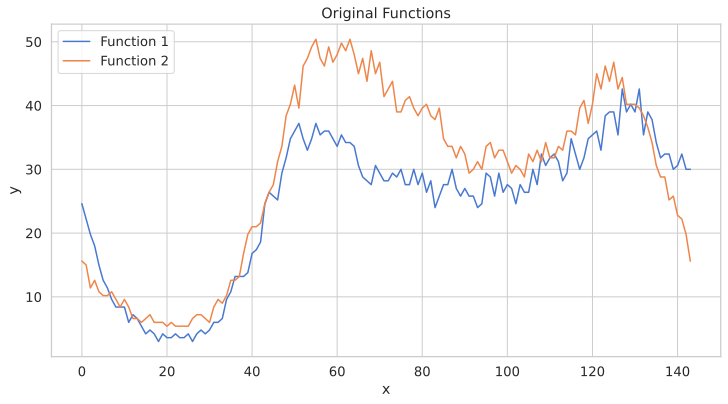

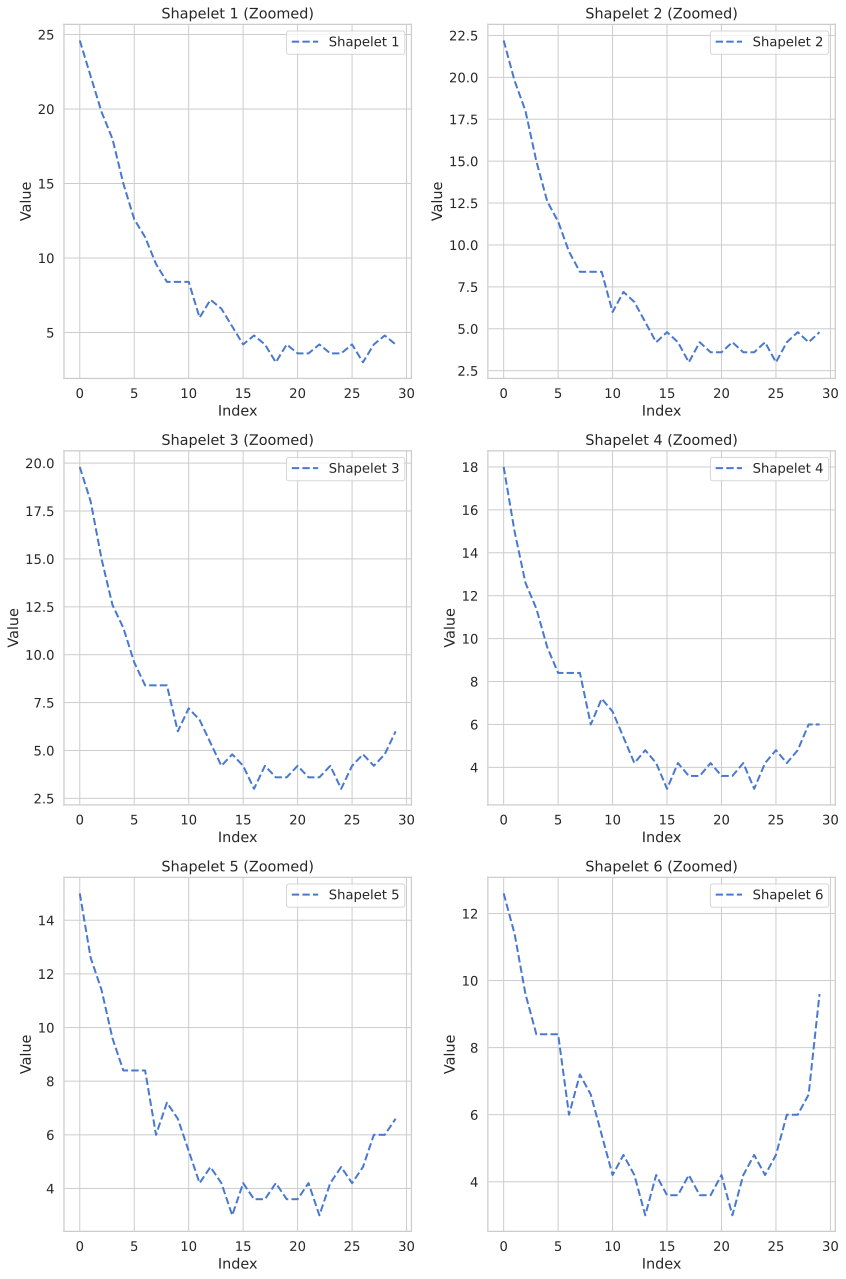

CPU times: user 13 s, sys: 21 ms, total: 13 s
Wall time: 13.2 s


In [5]:
%%time
shapelets = dynamic_shapelets(data, labels = [0,1], min_len=30, max_len=100, top_k=6)

# Plot functions
plt.figure(figsize=(12, 6))
plt.plot(series1, label="Function 1")
plt.plot(series2, label="Function 2")
plt.legend()
plt.title("Original Functions")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot shapelets
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
for i, shapelet in enumerate(shapelets):
    axes[i].plot(shapelet, linestyle='dashed', linewidth=2, label=f"Shapelet {i+1}")
    axes[i].legend()
    axes[i].set_title(f"Shapelet {i+1} (Zoomed)")
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("Value")
plt.tight_layout()
plt.show()

In [6]:
series1 = waterworks[waterworks.weekday].values[:,1:]
series2 = waterworks[~waterworks.weekday].values[:,1:]

252.216 --> 177.390 --> 173.624 --> 172.511 --> 171.887 --> 171.435 --> 171.106 --> 170.852 --> 170.652 --> 170.475 --> 170.326 --> 170.188 --> 170.071 --> 169.969 --> 169.885 --> 169.809 --> 169.743 --> 169.687 --> 169.641 --> 169.602 --> 169.567 --> 169.528 --> 169.490 --> 169.454 --> 169.404 --> 169.371 --> 169.343 --> 169.325 --> 169.308 --> 169.291 --> 169.278 --> 169.265 --> 169.252 --> 169.240 --> 169.227 --> 169.215 --> 169.203 --> 169.192 --> 169.180 --> 169.169 --> 169.158 --> 169.149 --> 


100%|██████████| 100/100 [05:11<00:00,  3.11s/it]


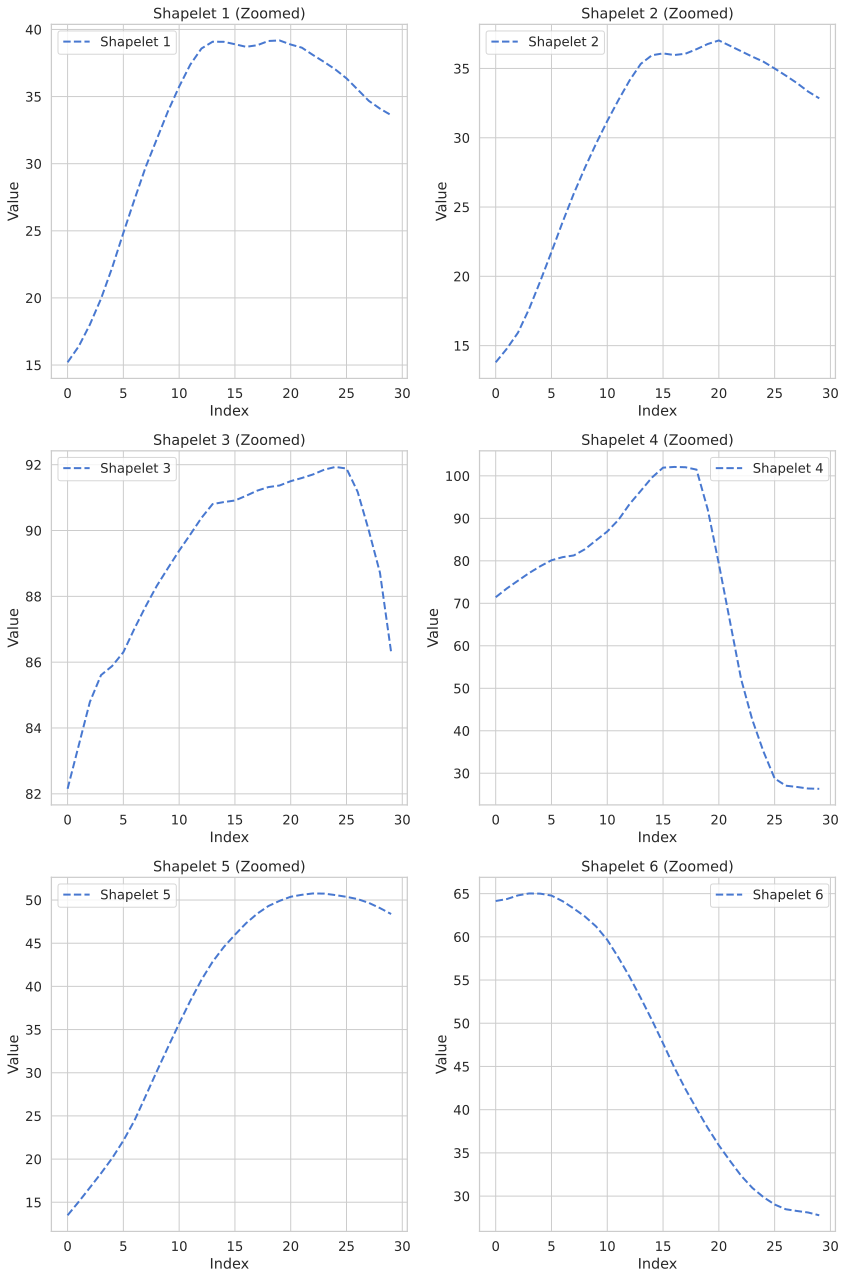

CPU times: user 7min 13s, sys: 400 ms, total: 7min 14s
Wall time: 7min 11s


In [14]:
%%time
series1 = waterworks[waterworks.weekday].values[:,1:]
series2 = waterworks[~waterworks.weekday].values[:,1:]
data = np.vstack([series1, series2])


shapelets = fixed_shapelets(data, labels = [0]*len(series1) + [1]*len(series2), window_size=30, top_k=6, n_clusters=100)
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
for i, shapelet in enumerate(shapelets):
    axes[i].plot(shapelet, linestyle='dashed', linewidth=2, label=f"Shapelet {i+1}")
    axes[i].legend()
    axes[i].set_title(f"Shapelet {i+1} (Zoomed)")
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("Value")
plt.tight_layout()
plt.show()